In [1]:
from hdfs import InsecureClient
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
hdfs_client = InsecureClient('http://49.173.80.183:14000')

In [3]:
def get_hdfs_list(client):
        file_list = client.list('/air02/')
        return file_list

In [4]:
filelist = get_hdfs_list(hdfs_client)

sum_df = pd.DataFrame()

for i in filelist:
       file_path = '/air02/'+str(i)
       with hdfs_client.read(file_path) as f: 
            df = pd.read_csv(f)
            df = df.drop(df.columns[0],axis=1)
            sum_df = pd.concat([sum_df,df])

In [5]:
sum_df

,date,station_no,stationName_x,time,parkingBikeTotCnt,addr1,addr2,T1H,PTY,RN1,TOT_LVPOP_CO
0,20240329,1124,1124. 발산역 6번 출구 뒤,1620,7,우장산동,강서구,12.8,0,0.0,33347.5255
1,20240329,1153,"1153. 발산역 1번, 9번 인근 대여소",1620,22,가양1동,강서구,12.8,0,0.0,43955.2083
2,20240329,2701,2701. 마곡나루역 5번출구 뒤편,1620,19,가양1동,강서구,12.8,0,0.0,43955.2083
3,20240329,2715,2715.마곡나루역 2번 출구,1620,34,가양1동,강서구,12.8,0,0.0,43955.2083
4,20240329,2721,2721.등촌1-10단지 교차로,1620,3,가양1동,강서구,12.8,0,0.0,43955.2083
...,...,...,...,...,...,...,...,...,...,...,...
5,20240401,2728,2728.마곡나루역 3번 출구,1655,66,가양1동,강서구,16.9,0,0.0,65372.8361
6,20240401,1158,1158. 가양역 8번출구,1655,9,가양2동,강서구,16.9,0,0.0,16133.0252
7,20240401,1160,1160. 양천향교역 7번출구앞,1655,3,등촌3동,강서구,16.9,0,0.0,41713.6763
8,20240401,1166,1166. 강서구립등빛도서관,1655,13,등촌3동,강서구,16.9,0,0.0,41713.6763


In [6]:
total_docks = {
    1124: 6,
    1153: 17,
    1158: 20,
    1160: 20,
    1166: 10,
    2701: 26,
    2715: 25,
    2721: 12,
    2728: 55,
    3798: 11
}

In [7]:
# 거치대 수량을 해당 대여소의 총 거치대 수로 나누는 함수 정의
def calculate_dock_ratio(row):
    station_id = row['station_no']
    if station_id in total_docks:
        total_dock = total_docks[station_id]
        return row['parkingBikeTotCnt'] / total_dock
    else:
        return None  # 대여소 번호가 사전에 없는 경우 None 반환

In [8]:
sum_df['date']=sum_df['date'].astype('str')
sum_df['time']=sum_df['time'].astype('str')
sum_df['거치대비율'] = sum_df.apply(calculate_dock_ratio, axis=1)

In [9]:
sum_df

,date,station_no,stationName_x,time,parkingBikeTotCnt,addr1,addr2,T1H,PTY,RN1,TOT_LVPOP_CO,거치대비율
0,20240329,1124,1124. 발산역 6번 출구 뒤,1620,7,우장산동,강서구,12.8,0,0.0,33347.5255,1.166667
1,20240329,1153,"1153. 발산역 1번, 9번 인근 대여소",1620,22,가양1동,강서구,12.8,0,0.0,43955.2083,1.294118
2,20240329,2701,2701. 마곡나루역 5번출구 뒤편,1620,19,가양1동,강서구,12.8,0,0.0,43955.2083,0.730769
3,20240329,2715,2715.마곡나루역 2번 출구,1620,34,가양1동,강서구,12.8,0,0.0,43955.2083,1.360000
4,20240329,2721,2721.등촌1-10단지 교차로,1620,3,가양1동,강서구,12.8,0,0.0,43955.2083,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
5,20240401,2728,2728.마곡나루역 3번 출구,1655,66,가양1동,강서구,16.9,0,0.0,65372.8361,1.200000
6,20240401,1158,1158. 가양역 8번출구,1655,9,가양2동,강서구,16.9,0,0.0,16133.0252,0.450000
7,20240401,1160,1160. 양천향교역 7번출구앞,1655,3,등촌3동,강서구,16.9,0,0.0,41713.6763,0.150000
8,20240401,1166,1166. 강서구립등빛도서관,1655,13,등촌3동,강서구,16.9,0,0.0,41713.6763,1.300000


In [10]:
sum_df['datetime'] = pd.to_datetime(sum_df['date'] + sum_df['time'], format='%Y%m%d%H%M')

In [11]:
sum_df

,date,station_no,stationName_x,time,parkingBikeTotCnt,addr1,addr2,T1H,PTY,RN1,TOT_LVPOP_CO,거치대비율,datetime
0,20240329,1124,1124. 발산역 6번 출구 뒤,1620,7,우장산동,강서구,12.8,0,0.0,33347.5255,1.166667,2024-03-29 16:20:00
1,20240329,1153,"1153. 발산역 1번, 9번 인근 대여소",1620,22,가양1동,강서구,12.8,0,0.0,43955.2083,1.294118,2024-03-29 16:20:00
2,20240329,2701,2701. 마곡나루역 5번출구 뒤편,1620,19,가양1동,강서구,12.8,0,0.0,43955.2083,0.730769,2024-03-29 16:20:00
3,20240329,2715,2715.마곡나루역 2번 출구,1620,34,가양1동,강서구,12.8,0,0.0,43955.2083,1.360000,2024-03-29 16:20:00
4,20240329,2721,2721.등촌1-10단지 교차로,1620,3,가양1동,강서구,12.8,0,0.0,43955.2083,0.250000,2024-03-29 16:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,20240401,2728,2728.마곡나루역 3번 출구,1655,66,가양1동,강서구,16.9,0,0.0,65372.8361,1.200000,2024-04-01 16:55:00
6,20240401,1158,1158. 가양역 8번출구,1655,9,가양2동,강서구,16.9,0,0.0,16133.0252,0.450000,2024-04-01 16:55:00
7,20240401,1160,1160. 양천향교역 7번출구앞,1655,3,등촌3동,강서구,16.9,0,0.0,41713.6763,0.150000,2024-04-01 16:55:00
8,20240401,1166,1166. 강서구립등빛도서관,1655,13,등촌3동,강서구,16.9,0,0.0,41713.6763,1.300000,2024-04-01 16:55:00


In [12]:
# '대여소번호'를 'ID'로, '거치대수량'을 'count'로 이름 변경
sum_df.rename(columns={'station_no': 'ID', 'parkingBikeTotCnt': 'count', 'time' : 'hour', '거치대비율':'ratio'}, inplace=True)

In [13]:
sum_df

,date,ID,stationName_x,hour,count,addr1,addr2,T1H,PTY,RN1,TOT_LVPOP_CO,ratio,datetime
0,20240329,1124,1124. 발산역 6번 출구 뒤,1620,7,우장산동,강서구,12.8,0,0.0,33347.5255,1.166667,2024-03-29 16:20:00
1,20240329,1153,"1153. 발산역 1번, 9번 인근 대여소",1620,22,가양1동,강서구,12.8,0,0.0,43955.2083,1.294118,2024-03-29 16:20:00
2,20240329,2701,2701. 마곡나루역 5번출구 뒤편,1620,19,가양1동,강서구,12.8,0,0.0,43955.2083,0.730769,2024-03-29 16:20:00
3,20240329,2715,2715.마곡나루역 2번 출구,1620,34,가양1동,강서구,12.8,0,0.0,43955.2083,1.360000,2024-03-29 16:20:00
4,20240329,2721,2721.등촌1-10단지 교차로,1620,3,가양1동,강서구,12.8,0,0.0,43955.2083,0.250000,2024-03-29 16:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,20240401,2728,2728.마곡나루역 3번 출구,1655,66,가양1동,강서구,16.9,0,0.0,65372.8361,1.200000,2024-04-01 16:55:00
6,20240401,1158,1158. 가양역 8번출구,1655,9,가양2동,강서구,16.9,0,0.0,16133.0252,0.450000,2024-04-01 16:55:00
7,20240401,1160,1160. 양천향교역 7번출구앞,1655,3,등촌3동,강서구,16.9,0,0.0,41713.6763,0.150000,2024-04-01 16:55:00
8,20240401,1166,1166. 강서구립등빛도서관,1655,13,등촌3동,강서구,16.9,0,0.0,41713.6763,1.300000,2024-04-01 16:55:00


In [14]:
df = sum_df[['ID', 'date', 'hour', 'count', 'datetime', 'ratio']]
df

,ID,date,hour,count,datetime,ratio
0,1124,20240329,1620,7,2024-03-29 16:20:00,1.166667
1,1153,20240329,1620,22,2024-03-29 16:20:00,1.294118
2,2701,20240329,1620,19,2024-03-29 16:20:00,0.730769
3,2715,20240329,1620,34,2024-03-29 16:20:00,1.360000
4,2721,20240329,1620,3,2024-03-29 16:20:00,0.250000
...,...,...,...,...,...,...
5,2728,20240401,1655,66,2024-04-01 16:55:00,1.200000
6,1158,20240401,1655,9,2024-04-01 16:55:00,0.450000
7,1160,20240401,1655,3,2024-04-01 16:55:00,0.150000
8,1166,20240401,1655,13,2024-04-01 16:55:00,1.300000


In [15]:
grouped = df.groupby('ID')

In [16]:
# 시퀀스 데이터로 변환하는 함수
def create_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X.iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(y.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

look_back = 3  # 과거 3개의 시간 단계를 사용하여 다음 단계를 예측

In [17]:
from sklearn.preprocessing import MinMaxScaler

# 정규화를 위한 스케일러 초기화
scaler = MinMaxScaler()

df['ratio_scaled'] = scaler.fit_transform(df['ratio'].values.reshape(-1,1))
# 결과 확인
print(df.head())

     ID      date  hour  count            datetime     ratio  ratio_scaled
0  1124  20240329  1620      7 2024-03-29 16:20:00  1.166667      0.205882
1  1153  20240329  1620     22 2024-03-29 16:20:00  1.294118      0.228374
2  2701  20240329  1620     19 2024-03-29 16:20:00  0.730769      0.128959
3  2715  20240329  1620     34 2024-03-29 16:20:00  1.360000      0.240000
4  2721  20240329  1620      3 2024-03-29 16:20:00  0.250000      0.044118


C:\Users\taeeon.kim\AppData\Local\Temp\ipykernel_21088\2108619879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ratio_scaled'] = scaler.fit_transform(df['ratio'].values.reshape(-1,1))


In [18]:
df['hour']=df['hour'].astype('int64')

C:\Users\taeeon.kim\AppData\Local\Temp\ipykernel_21088\2208270468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']=df['hour'].astype('int64')


In [19]:
df

,ID,date,hour,count,datetime,ratio,ratio_scaled
0,1124,20240329,1620,7,2024-03-29 16:20:00,1.166667,0.205882
1,1153,20240329,1620,22,2024-03-29 16:20:00,1.294118,0.228374
2,2701,20240329,1620,19,2024-03-29 16:20:00,0.730769,0.128959
3,2715,20240329,1620,34,2024-03-29 16:20:00,1.360000,0.240000
4,2721,20240329,1620,3,2024-03-29 16:20:00,0.250000,0.044118
...,...,...,...,...,...,...,...
5,2728,20240401,1655,66,2024-04-01 16:55:00,1.200000,0.211765
6,1158,20240401,1655,9,2024-04-01 16:55:00,0.450000,0.079412
7,1160,20240401,1655,3,2024-04-01 16:55:00,0.150000,0.026471
8,1166,20240401,1655,13,2024-04-01 16:55:00,1.300000,0.229412


In [20]:
# 각 그룹(대여소) 별로 모델 학습을 위한 딕셔너리
history_dict = {}

for ID, group in grouped:
    # 현재 그룹(대여소)의 데이터
    stop_data = group
    
    # 입력 변수와 예측할 변수
    X = stop_data[['hour', 'ratio_scaled']]  # ratio_scaled 대신 ratio 사용 (예시 변경 가능)
    y = stop_data['ratio_scaled']  # ratio_scaled 대신 ratio 사용 (예시 변경 가능)
    
    # 시퀀스 데이터 생성 (create_dataset 함수는 정의되어 있어야 함)
    X_seq, y_seq = create_dataset(X, y, look_back)
    
    # 학습 및 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    # LSTM 모델 구성
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2, validation_split=0.2)
    
    # 학습 과정 저장
    history_dict[ID] = history



Epoch 1/10

304/304 - 3s - loss: 342.3171 - val_loss: 0.4321 - 3s/epoch - 9ms/step
Epoch 2/10
304/304 - 1s - loss: 5.4814 - val_loss: 0.3694 - 571ms/epoch - 2ms/step
Epoch 3/10
304/304 - 1s - loss: 1.3733 - val_loss: 0.4331 - 566ms/epoch - 2ms/step
Epoch 4/10
304/304 - 1s - loss: 0.5576 - val_loss: 0.4058 - 562ms/epoch - 2ms/step
Epoch 5/10
304/304 - 1s - loss: 0.6640 - val_loss: 0.3959 - 579ms/epoch - 2ms/step
Epoch 6/10
304/304 - 1s - loss: 0.6611 - val_loss: 0.5927 - 695ms/epoch - 2ms/step
Epoch 7/10
304/304 - 1s - loss: 0.7681 - val_loss: 0.3511 - 592ms/epoch - 2ms/step
Epoch 8/10
304/304 - 1s - loss: 1.3932 - val_loss: 0.5966 - 644ms/epoch - 2ms/step
Epoch 9/10
304/304 - 1s - loss: 2.1759 - val_loss: 0.3183 - 606ms/epoch - 2ms/step
Epoch 10/10
304/304 - 1s - loss: 1.0921 - val_loss: 0.7035 - 599ms/epoch - 2ms/step
Epoch 1/10
304/304 - 2s - loss: 180.3213 - val_loss: 0.5344 - 2s/epoch - 8ms/step
Epoch 2/10
304/304 - 1s - loss: 3.9191 - val_loss: 1.6113 - 568ms/epoch - 2ms/step
Ep

Epoch 2/10
304/304 - 1s - loss: 102.4551 - val_loss: 155.5070 - 591ms/epoch - 2ms/step
Epoch 3/10
304/304 - 1s - loss: 61.0432 - val_loss: 1.2238 - 594ms/epoch - 2ms/step
Epoch 4/10
304/304 - 1s - loss: 13.2419 - val_loss: 0.1230 - 564ms/epoch - 2ms/step
Epoch 5/10
304/304 - 1s - loss: 5.5973 - val_loss: 0.2022 - 575ms/epoch - 2ms/step
Epoch 6/10
304/304 - 1s - loss: 7.3040 - val_loss: 0.0710 - 559ms/epoch - 2ms/step
Epoch 7/10
304/304 - 1s - loss: 3.6441 - val_loss: 0.1894 - 570ms/epoch - 2ms/step
Epoch 8/10
304/304 - 1s - loss: 5.9280 - val_loss: 0.0615 - 583ms/epoch - 2ms/step
Epoch 9/10
304/304 - 1s - loss: 79.9347 - val_loss: 0.0793 - 538ms/epoch - 2ms/step
Epoch 10/10
304/304 - 1s - loss: 0.1254 - val_loss: 0.1138 - 578ms/epoch - 2ms/step


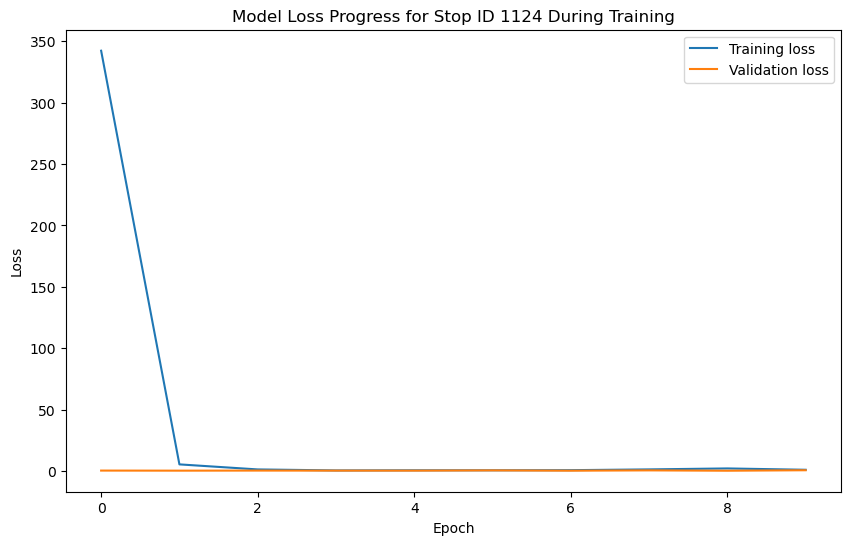

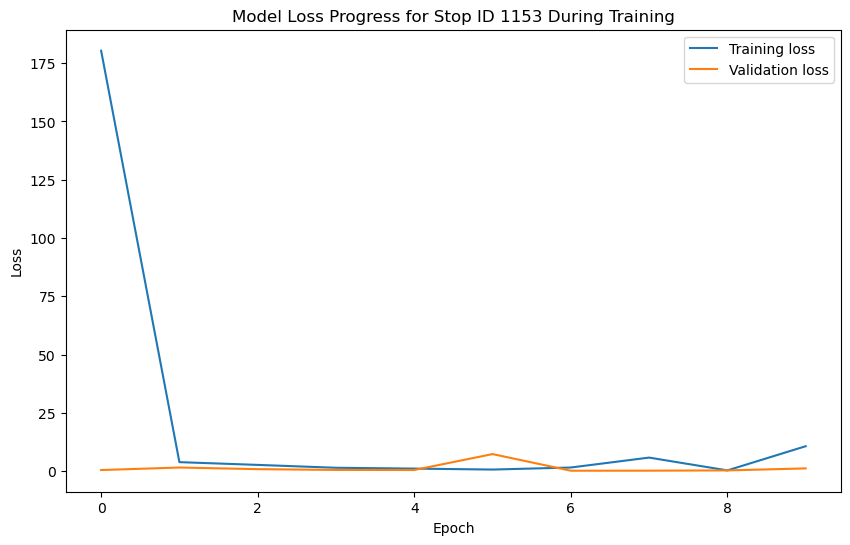

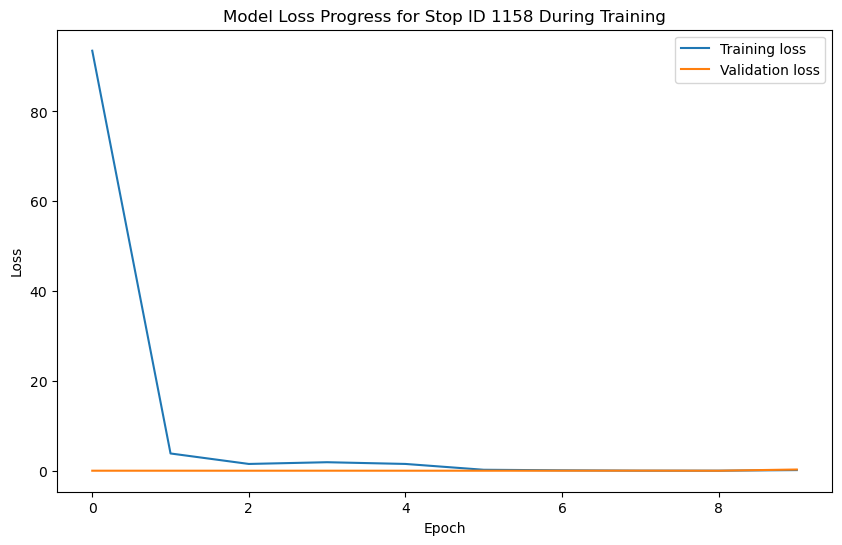

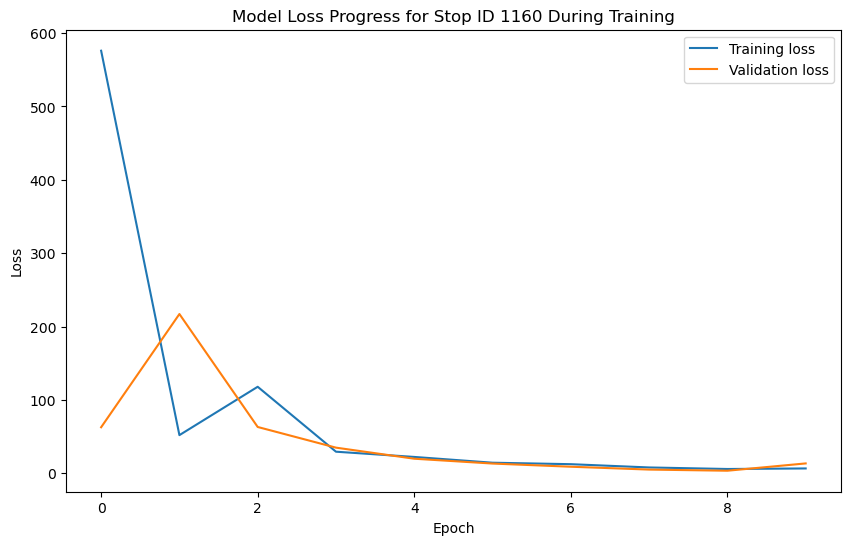

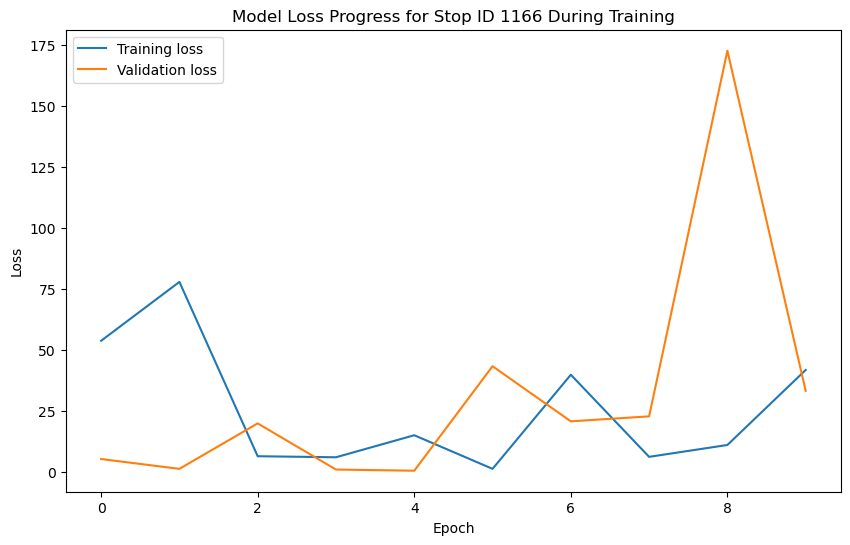

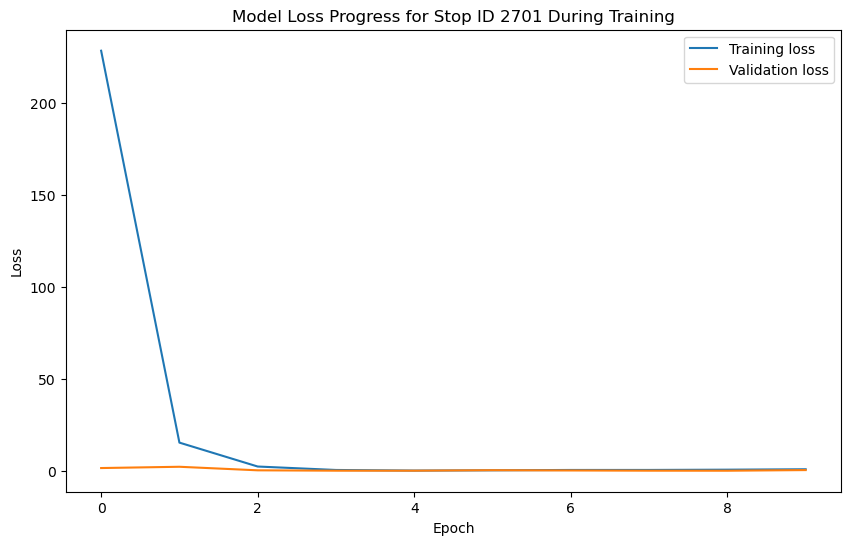

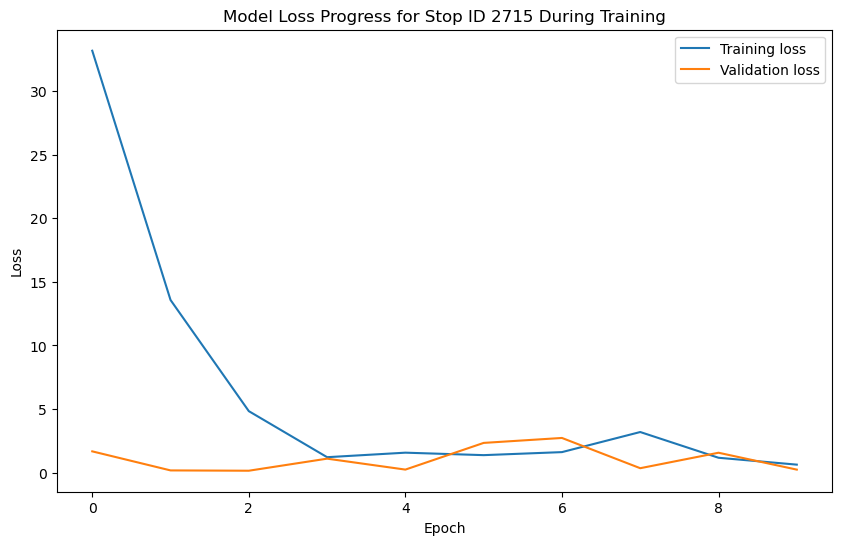

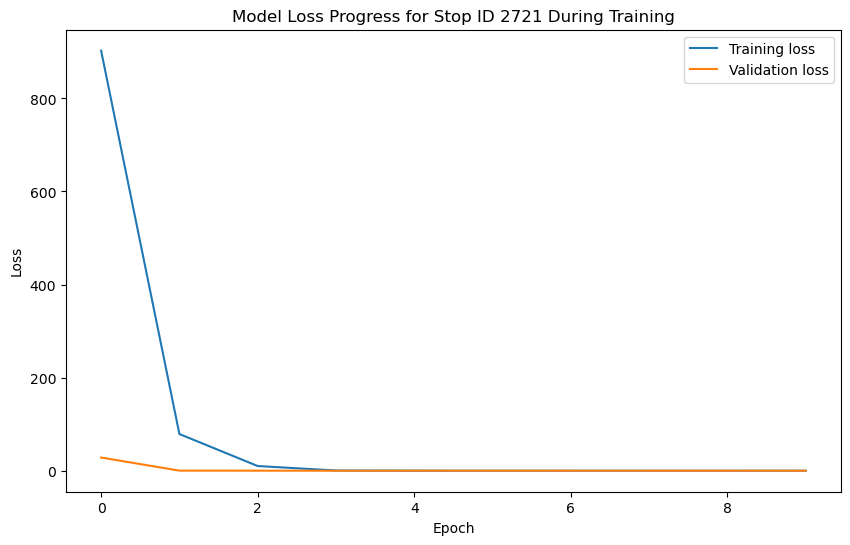

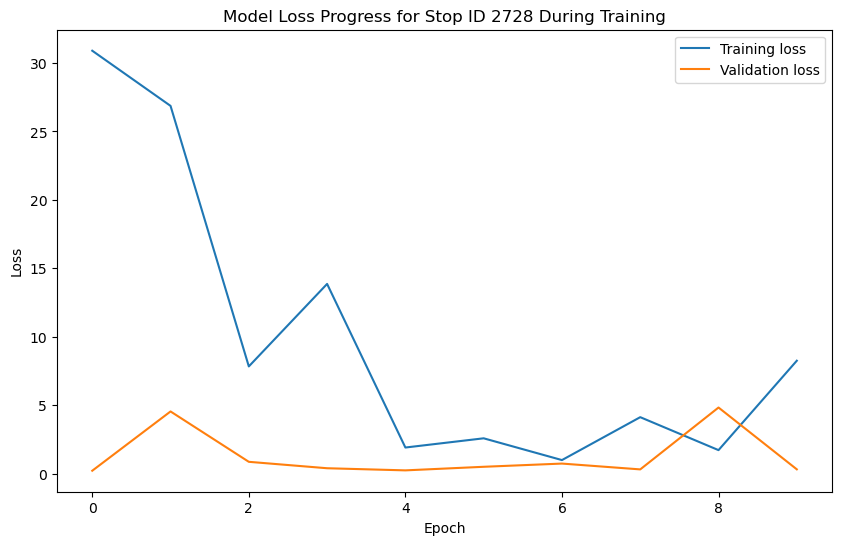

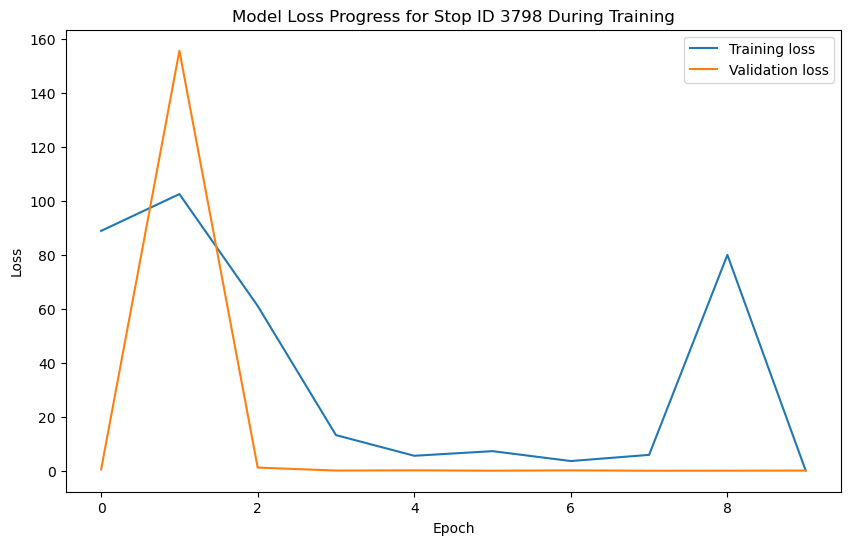

In [21]:
import matplotlib.pyplot as plt

for ID, history in history_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f'Model Loss Progress for Stop ID {ID} During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()